In [127]:
#write the code for linear regression
class linear_regression():
    def __init__(self):
        self.X = None
        self.variables = None
        self.y = None
        self.predictor = None
        self.n = None
        self.p = None
        self.bias = None
        self.beta_hat = None
        self.y_hat = None

    # model fitting
    def fit(self, X, y, bias=True):
        self.variables = X.columns
        self.predictor = y.name
        
        X = X.to_numpy()
        y = y.to_numpy()

        if bias:
            ones_column = np.ones((X.shape[0], 1))
            X = np.append(ones_column, X, axis=1)

        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.p = X.shape[1]
        self.bias = bias


        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
        self.beta_hat = beta_hat
        self.y_hat = X @ beta_hat

    # predict new data
    def predict(self, x):
        if self.bias:
            ones_column = np.ones((x.shape[0], 1))
            x = np.append(ones_column, x, axis=1)
        return x @ self.beta_hat

    # function of sum of squared errors
    def SSE(self):
        return (self.y-self.y_hat).T@(self.y-self.y_hat)
    
    # function of mean squared errors
    def MSE(self):
        return self.SSE()/(self.n-self.p)

    # function of sum of squares regression
    def SSR(self):
        return (self.y_hat - np.mean(self.y)).T @ (self.y_hat - np.mean(self.y))

    # function of mean squared regression
    def MSR(self):
        return self.SSR()/(self.p-1)

    # function of sum of squares total
    def SST(self):
        return (self.y-np.mean(self.y_hat)).T@(self.y-np.mean(self.y_hat))

    # function of coefficient of determination
    def R_2(self):
        return 1 - self.SSE()/self.SST()

    # function of coefficient of determination on test data
    def pred_R_2(self, input, true):
        pred = self.predict(input)
        pred_SSE = (true-pred).T@(true-pred)
        pred_SST = (true-np.mean(pred)).T@(true-np.mean(pred))
        return 1 - pred_SSE/pred_SST

    # function of adjusted coefficient of determination
    def adj_R_2(self):
        return 1- (1-self.R_2())*(self.n-1)/(self.n-self.p-1)

    # function of standard deviation of coefficients
    def sd_coef(self):
        return np.sqrt(np.diagonal(self.MSE() * np.linalg.inv(self.X.T @ self.X)))

    # function of t statistic and p-value
    def t_stat(self):
        t = self.beta_hat / self.sd_coef()
        t_p = [2*(1-stats.t.cdf(np.abs(i), (self.n-self.p-1))) for i in t]
        return t, t_p

    # function of F statistic and p-value
    def F_stat(self):
        F = self.MSR()/self.MSE()
        df_1 = self.p - 1
        df_2 = self.n - self.p
        #find p-value of F test statistic 
        F_p = 1-stats.f.cdf(F, df_1, df_2) 
        return F, F_p

    # function of root mean square error
    def RMSE(self, input, true):
        pred = self.predict(input)
        return np.sqrt((true-pred).T@(true-pred)/len(true))

    # function of model summary
    def summary(self):
        coef_df = pd.DataFrame()
        
        coef_df['Estimate'] = self.beta_hat
        coef_df['Std.Error'] = self.sd_coef()
        coef_df['t value'] = self.t_stat()[0]
        coef_df['Pr(>|t|)'] = self.t_stat()[1]
        coef_df.index = ['Intercept'] + list(self.variables)

        print(coef_df)

        print(f"Residual standard error: {round(np.sqrt(self.MSE()), 3)} on {self.n-self.p} degress of freedom.")
        print(f"R-squared: {round(self.R_2(), 3)}, Adjusted R-square: {round(self.adj_R_2(), 3)}")
        f_stat_str = f"F-statistic: {round(self.F_stat()[0], 3)} on {self.p - 1} and {self.n - self.p} DF,"
        f_p_str = f"p-value: {round(self.F_stat()[1], 3)}"
        print(f_stat_str + f_p_str)

In [128]:
#import the modules necessary
import numpy as np
import pandas as pd
from scipy import stats
import pandas_datareader as web
import plotly.express as px
import statsmodels.api as sm
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime as dt

In [180]:
#Import stock data from Naver from the specified dates
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2020, 12, 31)
data = web.DataReader('005930', 'naver', start_date, end_date)

data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,55500,56000,55000,55200,12993228
2020-01-03,56000,56600,54900,55500,15422255
2020-01-06,54900,55600,54600,55500,10278951
2020-01-07,55700,56400,55600,55800,10009778
2020-01-08,56200,57400,55900,56800,23501171


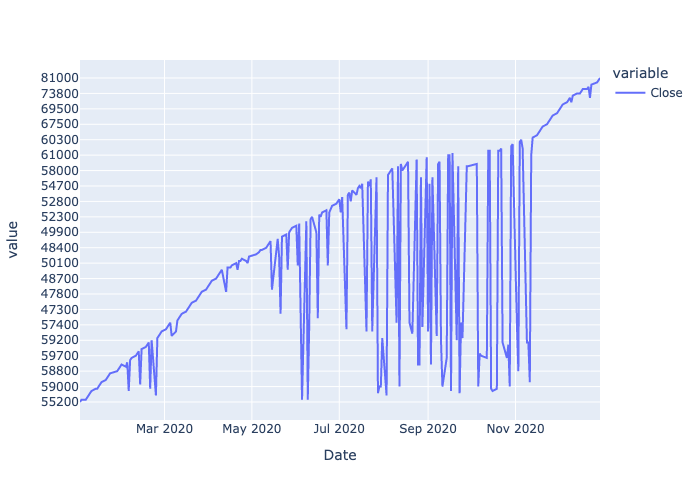

In [181]:
#Plot the close price of the data at the selected date
all_df = pd.DataFrame(data['Close'])

fig = px.line(all_df)
fig.show("png")

In [200]:
#Use the past 6 days to predict the current
for i in range(1, 6):
    all_df[f'lag_{i}'] = all_df['Close'].shift(i)
    
all_df.head(10)

,Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2020-01-20,62400,None,None,None,None,None,59500,58600
2020-01-21,61400,62400,None,None,None,None,60000,59500
2020-01-22,62300,61400,62400,None,None,None,60000,60000
2020-01-23,60800,62300,61400,62400,None,None,59000,60000
2020-01-28,58800,60800,62300,61400,62400,None,60700,59000
2020-01-29,59100,58800,60800,62300,61400,62400,61300,60700
2020-01-30,57200,59100,58800,60800,62300,61400,62400,61300
2020-01-31,56400,57200,59100,58800,60800,62300,61400,62400
2020-02-03,57200,56400,57200,59100,58800,60800,62300,61400


In [201]:
all_df.dropna(inplace=True)
cols = [f'lag_{i}' for i in range(1, 8)]

train_df = all_df.iloc[0:181-4, :]
train_df.head(5)

,Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2020-01-29,59100,58800,60800,62300,61400,62400,61300,60700
2020-01-30,57200,59100,58800,60800,62300,61400,62400,61300
2020-01-31,56400,57200,59100,58800,60800,62300,61400,62400
2020-02-03,57200,56400,57200,59100,58800,60800,62300,61400
2020-02-04,58900,57200,56400,57200,59100,58800,60800,62300


In [202]:
X = train_df[cols]
y = train_df['Close']
model = linear_regression()
X = X.astype('int')
y = y.astype('int')
model.fit(X, y)

In [203]:
model.summary()


              Estimate    Std.Error    t value  Pr(>|t|)
Intercept  1581.392468  1088.098063   1.453355  0.147991
lag_1         0.953385     0.076279  12.498688  0.000000
lag_2         0.170711     0.105775   1.613906  0.108424
lag_3        -0.184798     0.105870  -1.745525  0.082722
lag_4        -0.022012     0.106421  -0.206843  0.836383
lag_5         0.042400     0.105346   0.402483  0.687841
lag_6        -0.000801     0.104625  -0.007659  0.993898
lag_7         0.012108     0.075616   0.160118  0.872980
Residual standard error: 1124.693 on 169 degress of freedom.
R-squared: 0.938, Adjusted R-square: 0.935
F-statistic: 366.884 on 7 and 169 DF,p-value: 0.0


In [204]:
RMSE = model.RMSE(X, y)
print(f"The RMSE of training data is: {round(RMSE, 3)}")

The RMSE of training data is: 1098.983


The R-squared value is 0.938 which is not bad. The RMSE is 1098 is not bad considering that the values of the dataset are 5 digits. 

/var/folders/87/qv3j_nd52_j7ggymlb8yrgtr0000gq/T/ipykernel_89008/2433450901.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/87/qv3j_nd52_j7ggymlb8yrgtr0000gq/T/ipykernel_89008/2433450901.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



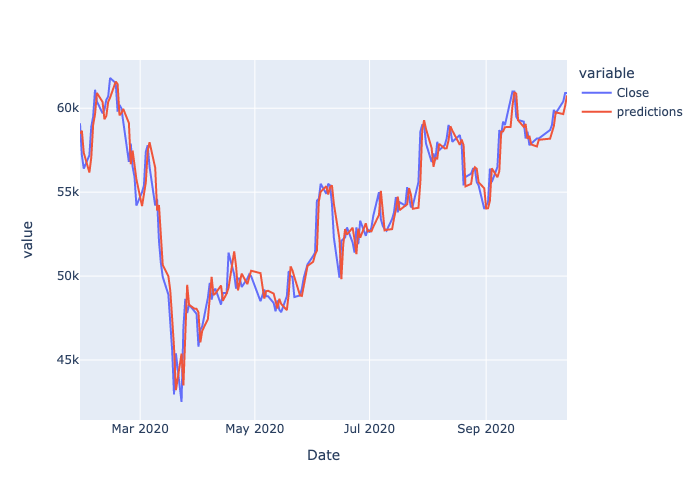

In [205]:
train_df['predictions'] = model.predict(X).astype('float')
train_df['Close'] = train_df['Close'].astype('float')

fig = px.line(train_df, y=['Close','predictions'])


fig.show("png")

The overlaid graph demonstrates that the model did a good prediction of the actual close values. 

In [178]:
X_n = sm.add_constant(X)
sm.OLS(y, X_n).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1101.
Date:                Wed, 17 Apr 2024   Prob (F-statistic):          1.45e-135
Time:                        21:05:40   Log-Likelihood:                -1361.7
No. Observations:                 174   AIC:                             2739.
Df Residuals:                     166   BIC:                             2765.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        455.2911    510.137      0.892      0.373    -551.903    1462.485
lag_1          1.0864      0.078     14.013      0.000       0.933       1.239
lag_2         -0.0876      0.114     -0.767      0.444      -0.313       0.138
lag_3         -0.0394      0.114     -0.345      0.731      -0.265       0.186
lag_4          0.0736      0.114      0.647      0.518      -0.151       0.298
lag_5         -0.0546      0.117     -0.467      0.641      -0.285       0.176
lag_6          0.0542      0.118      0.457      0.648      -0.180       0.288
lag_7         -0.0410      0.079     -0.517      0.606      -0.198       0.116
==============================================================================
Omnibus:                        5.842   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                8.275
Skew:                          -0.133   Prob(JB):                       0.0160
Kurtosis:                       4.035   Cond. No.                     1.27e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Based on the RSME values, R square value, and the plot results, the linear regression model did a good job of predicting the stock data. 